In [1]:
%%time
import os
import sys
import math
from math import sqrt
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

CPU times: total: 11.5 s
Wall time: 13.7 s


In [2]:
%%time
quina = pd.read_excel("HIST_SORTEIOS_QUINA.xlsx")

CPU times: total: 1.45 s
Wall time: 1.68 s


In [3]:
quina2 = quina[(quina['Data Sorteio']>='2013-01-01') ]

In [4]:
quina2.head()

,Concurso,Data Sorteio,1ª Dezena,2ª Dezena,3ª Dezena,4ª Dezena,5ª Dezena
3083,3084,2013-01-02,17,28,30,31,47
3084,3085,2013-01-03,12,28,30,36,39
3085,3086,2013-01-04,12,14,27,53,74
3086,3087,2013-01-05,15,16,41,46,47
3087,3088,2013-01-07,38,42,47,64,66


In [5]:
quina2.dtypes

Concurso                 int64
Data Sorteio    datetime64[ns]
1ª Dezena                int64
2ª Dezena                int64
3ª Dezena                int64
4ª Dezena                int64
5ª Dezena                int64
dtype: object

In [6]:
quina2.shape

(3088, 7)

In [22]:
# Colocar os valores em ordem crescente em cada linha
# A ideia é ter uma série dos menores valores, dos seguindos menores valores, e etc ...
a = quina2[['1ª Dezena','2ª Dezena','3ª Dezena','4ª Dezena','5ª Dezena']].values

In [23]:
a.sort(axis=1)  # no ascending argument

In [24]:
df = pd.DataFrame(a, quina2.index, ['1ª Dezena','2ª Dezena','3ª Dezena','4ª Dezena','5ª Dezena'])

In [25]:
df.head()

,1ª Dezena,2ª Dezena,3ª Dezena,4ª Dezena,5ª Dezena
3083,17,28,30,31,47
3084,12,28,30,36,39
3085,12,14,27,53,74
3086,15,16,41,46,47
3087,38,42,47,64,66


In [26]:
df.reset_index(inplace=True)
df.rename(columns={'index':'Concurso'},inplace=True)
df2 = quina2[['Concurso','Data Sorteio']].merge(df, on='Concurso')

In [27]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
         cols.append(df.shift(i))
         names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [37]:
values = values.reshape(-1,5)

In [38]:
values

array([[16., 27., 29., 30., 46.],
       [11., 27., 29., 35., 38.],
       [11., 13., 26., 52., 73.],
       ...,
       [ 0., 19., 30., 45., 57.],
       [31., 49., 55., 64., 69.],
       [18., 32., 51., 60., 77.]], dtype=float32)

In [39]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

In [48]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 5))
scaled = scaler.fit_transform(values)

n_hours = 3
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 1)

# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2   1.269841   1.830986   1.805556   1.619718   2.053571   0.873016   
3   0.873016   1.830986   1.805556   1.971831   1.339286   0.873016   
4   0.873016   0.845070   1.597222   3.169014   4.464286   1.111111   
5   1.111111   0.985916   2.569445   2.676056   2.053571   2.936508   
6   2.936508   2.816901   2.986111   3.943661   3.750000   0.238095   

   var7(t-2)  var8(t-2)  var9(t-2)  var10(t-2)  ...   var6(t)   var7(t)  \
2   1.830986   1.805556   1.971831    1.339286  ...  1.111111  0.985916   
3   0.845070   1.597222   3.169014    4.464286  ...  2.936508  2.816901   
4   0.985916   2.569445   2.676056    2.053571  ...  0.238095  1.478873   
5   2.816901   2.986111   3.943661    3.750000  ...  0.158730  0.704225   
6   1.478873   1.666667   2.183098    4.910715  ...  1.031746  1.760563   

    var8(t)   var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  \
2  2.569445  2.676056  2.053571  2.936508  2.81

In [49]:
print(reframed.shape)

(3084, 45)


In [50]:
# split into train and test sets
values = reframed.values
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 30) 2000 (2000,)
(2000, 3, 10) (2000,) (1084, 3, 10) (1084,)


In [51]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
28/28 - 3s - loss: 0.6413 - val_loss: 0.5592 - 3s/epoch - 112ms/step
Epoch 2/50
28/28 - 0s - loss: 0.5240 - val_loss: 0.4514 - 155ms/epoch - 6ms/step
Epoch 3/50
28/28 - 0s - loss: 0.3927 - val_loss: 0.3256 - 153ms/epoch - 5ms/step
Epoch 4/50
28/28 - 0s - loss: 0.2694 - val_loss: 0.2215 - 146ms/epoch - 5ms/step
Epoch 5/50
28/28 - 0s - loss: 0.1646 - val_loss: 0.1240 - 141ms/epoch - 5ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0871 - val_loss: 0.0543 - 136ms/epoch - 5ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0447 - val_loss: 0.0616 - 133ms/epoch - 5ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0360 - val_loss: 0.0457 - 131ms/epoch - 5ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0315 - val_loss: 0.0450 - 128ms/epoch - 5ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0286 - val_loss: 0.0387 - 139ms/epoch - 5ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0260 - val_loss: 0.0252 - 140ms/epoch - 5ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0263 - val_loss: 0.0249 - 140ms/epoch - 5ms/step
Epoch 13/50
28/28 - 0s - l

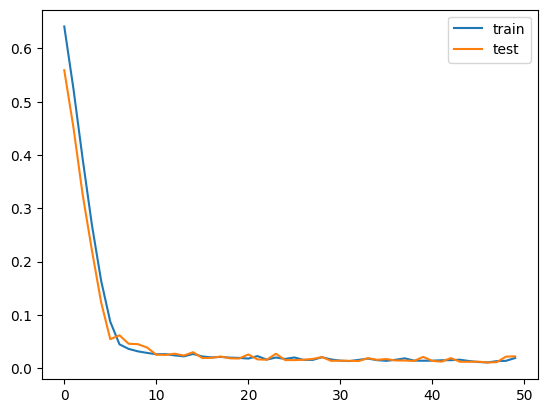

In [52]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [53]:
# make a prediction
yhat = model.predict(test_X)

34/34 [==============================] - 0s 1ms/step


In [54]:
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [55]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -10:]), axis=1)

In [56]:
inv_yhat.shape

(1084, 11)

In [57]:
# invert scaling for forecast
inv_yhat = scaler.inverse_transform(inv_yhat)

ValueError: operands could not be broadcast together with shapes (1084,11) (15,) (1084,11) 

In [ ]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [123]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape )

(700, 1, 9) (700,) (311, 9) (311,)
